# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Коваленко Павел Антонович

Группа: 317

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rc
%matplotlib inline

In [2]:
font = {'family': 'Verdana',
        'weight': 'normal',
        'size': 14}
rc('font', **font)
rc('legend', fontsize=14)

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [62]:
train_set = pd.read_csv('unimel_train.csv', index_col='Grant.Application.ID')
test_set = pd.read_csv('unimel_test.csv', index_col='Grant.Application.ID')

In [63]:
y_train = train_set['Grant.Status']
data_train = train_set.drop('Grant.Status', axis=1)
y_test = test_set['Grant.Status']
data_test = test_set.drop('Grant.Status', axis=1)

In [64]:
data_train.head()

,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,RFCD.Code.4,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
Grant.Application.ID,,,,,,,,,,,,,,,,,,,,,
1137,21A,50A,A,230202,50,230203,30,230204,20,0,...,3098,31,Yes,>=0 to 5,2,0,0,4,2,0
4314,4D,10A,D,320801,100,0,0,0,0,0,...,2553,25,Yes,>=0 to 5,3,1,0,2,0,0
2020,NaN,NaN,NaN,320602,50,321004,30,321015,20,0,...,2813,25,NaN,Less than 0,1,5,0,7,2,0
6777,51C,20C,A,291503,60,321402,40,0,0,0,...,2553,25,NaN,more than 15,2,1,5,6,9,1
409,24D,30B,NaN,380107,100,0,0,0,0,0,...,2923,25,NaN,Less than 0,0,2,0,0,0,0


In [65]:
data_train.shape

(6095, 38)

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

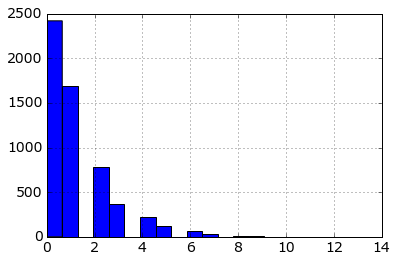

In [7]:
data_train['Number.of.Successful.Grant.1'].hist(bins=20)

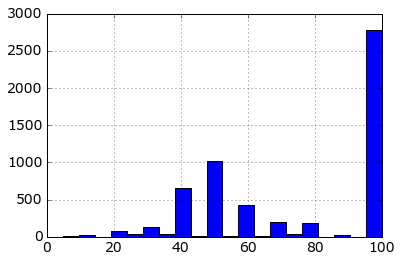

In [8]:
data_train['RFCD.Percentage.1'].hist(bins=20)

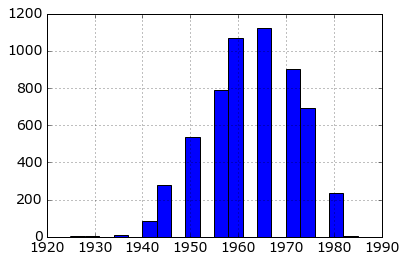

In [9]:
data_train['Year.of.Birth.1'].hist(bins=20)

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

Разные признаки имеют совершенно разные диапазоны значений. Чтобы градиентный спуск работал корректно, необходимо привести признаки к одной шкале. Иначе один и тот же шаг (например, 5) по одному из признаков (год рождения) не сильно изменит картину, а по другому (число успешных грантов) будет слишком большим. В итоге будет сложно подобрать такой шаг градиентного спуска, чтоб по всем параметрам он был одновременно достаточно большим, чтоб сойтись к оптимуму, и достаточно маленьким, чтобы оптимум не проскочить.

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
2. Сколько объектов имеют хотя бы один пропуск?
3. Сколько признаков имеют хотя бы одно пропущенное значение?

In [6]:
def checknan(x):
    if type(x) == str:
        return False
    else:
        return np.isnan(x)

In [7]:
train_nan = data_train.applymap(checknan)

In [8]:
train_nan.head()

,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,RFCD.Code.4,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
Grant.Application.ID,,,,,,,,,,,,,,,,,,,,,
1137,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4314,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2020,True,True,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
6777,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
409,False,False,True,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [9]:
train_nan.sum().sum()

26843

In [10]:
train_nan.any(axis=1).sum()

5879

In [11]:
train_nan.any(axis=0)

Sponsor.Code                              True
Grant.Category.Code                       True
Contract.Value.Band...see.note.A          True
RFCD.Code.1                               True
RFCD.Percentage.1                         True
RFCD.Code.2                               True
RFCD.Percentage.2                         True
RFCD.Code.3                               True
RFCD.Percentage.3                         True
RFCD.Code.4                               True
RFCD.Percentage.4                         True
RFCD.Code.5                               True
RFCD.Percentage.5                         True
SEO.Code.1                                True
SEO.Percentage.1                          True
SEO.Code.2                                True
SEO.Percentage.2                          True
SEO.Code.3                                True
SEO.Percentage.3                          True
SEO.Code.4                                True
SEO.Percentage.4                          True
SEO.Code.5   

Всего в выборке имеется почти 27000 пропущенных значений. При этом в каждом столбце имеется хотя бы одно пропущенное значение, и в большинстве объектов (5879 из 6095) есть хотя бы одно пропущенно поле.

Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [10]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [11]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print(simple_data_dict)

dict_values([{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}])


In [12]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её
matrix = transformer.fit_transform(simple_data_dict)
print(matrix)

[[ 1.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.]
 [ 1.  0.  0.  0.  1.]]


Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [303]:
def transform_data(data, scaler, transformer, is_test, scale=True):
    tdata = data.copy()
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    text_cols = list(set(data.columns).difference(numeric_cols))
    filldict = {}
    for i in numeric_cols:
        filldict[i] = 0
    for i in text_cols:
        filldict[i] = 'nan'
    tdata.fillna(value=filldict, inplace=True)
    if scale:
        if is_test:
            tdata[numeric_cols] = scaler.transform(tdata[numeric_cols])
        else:
            tdata[numeric_cols] = scaler.fit_transform(tdata[numeric_cols])
    
    tdata[text_cols] = tdata[text_cols].applymap(lambda x: str(x))
    text_dict = tdata[text_cols].to_dict(orient='records')
    if is_test:
        t = transformer.transform(text_dict)
    else:
        t = transformer.fit_transform(text_dict)
    tdata = pd.concat([tdata, pd.DataFrame.from_records(t, columns=transformer.feature_names_, index=tdata.index)], axis=1)
    tdata.drop(text_cols, inplace=True, axis=1)
    
    return tdata, scaler, transformer

Применяем функцию к данным:

In [92]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

C:\Anaconda3\lib\site-packages\pandas\core\internals.py:4417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  comp = (nn == nn_at)


In [94]:
X.head()

,RFCD.Percentage.1,RFCD.Percentage.2,RFCD.Percentage.3,RFCD.Percentage.4,RFCD.Percentage.5,SEO.Percentage.1,SEO.Percentage.2,SEO.Percentage.3,SEO.Percentage.4,SEO.Percentage.5,...,Sponsor.Code=90B,Sponsor.Code=91C,Sponsor.Code=93A,Sponsor.Code=94B,Sponsor.Code=95C,Sponsor.Code=97A,Sponsor.Code=9A,Sponsor.Code=nan,With.PHD.1=Yes,With.PHD.1=nan
Grant.Application.ID,,,,,,,,,,,,,,,,,,,,,
1137,-0.608451,0.703245,1.174904,-0.133272,-0.067022,1.058025,-0.950185,-0.552590,-0.182801,-0.096227,...,0,0,0,0,0,0,0,0,1,0
4314,0.945581,-0.854627,-0.559046,-0.133272,-0.067022,1.058025,-0.950185,-0.552590,-0.182801,-0.096227,...,0,0,0,0,0,0,0,0,1,0
2020,-0.608451,0.703245,1.174904,-0.133272,-0.067022,-0.195593,0.042362,1.179742,-0.182801,-0.096227,...,0,0,0,0,0,0,0,1,0,1
6777,-0.297645,1.222536,-0.559046,-0.133272,-0.067022,-0.195593,1.034909,-0.552590,-0.182801,-0.096227,...,0,0,0,0,0,0,0,0,0,1
409,0.945581,-0.854627,-0.559046,-0.133272,-0.067022,-0.508997,1.531183,-0.552590,-0.182801,-0.096227,...,0,0,0,0,0,0,0,0,0,1


Сколько признаков у вас получилось после преобразования?

In [95]:
print(X.shape[1])

5639


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [96]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

In [97]:
# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
gs = GridSearchCV(LogisticRegression(), param_grid={'C' : C_grid}, scoring='roc_auc', cv=cv, verbose=10)
gs.fit(X, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.863121 -   2.6s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.837991 -   2.3s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.823047 -   2.4s
[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.834639 -   2.5s

[Parallel(n_jobs=1)]: Done   1 tasks       | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   4 tasks       | elapsed:   10.6s



[CV] C=0.001 .........................................................
[CV] ................................ C=0.001, score=0.857035 -   2.3s
[CV] C=0.01 ..........................................................
[CV] ................................. C=0.01, score=0.888082 -   2.3s
[CV] C=0.01 ..........................................................
[CV] ................................. C=0.01, score=0.872970 -   2.5s
[CV] C=0.01 ..........................................................
[CV] ................................. C=0.01, score=0.856761 -   2.5s
[CV] C=0.01 ..........................................................
[CV] ................................. C=0.01, score=0.868401 -   2.5s
[CV] C=0.01 ..........................................................
[CV] ................................. C=0.01, score=0.878897 -   2.7s
[CV] C=0.1 ...........................................................
[CV] .................................. C=0.1, score=0.895421 -   2.6s
[CV] 

[Parallel(n_jobs=1)]: Done   7 tasks       | elapsed:   18.4s
[Parallel(n_jobs=1)]: Done  12 tasks       | elapsed:   32.2s



[CV] C=0.1 ...........................................................
[CV] .................................. C=0.1, score=0.868654 -   2.6s
[CV] C=0.1 ...........................................................
[CV] .................................. C=0.1, score=0.880399 -   2.5s
[CV] C=0.1 ...........................................................
[CV] .................................. C=0.1, score=0.884842 -   2.6s
[CV] C=1.0 ...........................................................
[CV] .................................. C=1.0, score=0.883633 -   2.9s
[CV] C=1.0 ...........................................................
[CV] .................................. C=1.0, score=0.875024 -   2.8s
[CV] C=1.0 ...........................................................
[CV] .................................. C=1.0, score=0.868268 -   2.8s
[CV] C=1.0 ...........................................................
[CV] .................................. C=1.0, score=0.870605 -   2.9s
[CV] 

[Parallel(n_jobs=1)]: Done  17 tasks       | elapsed:   46.6s
[Parallel(n_jobs=1)]: Done  24 tasks       | elapsed:  1.2min



[CV] C=10.0 ..........................................................
[CV] ................................. C=10.0, score=0.853429 -   3.3s
[CV] C=100.0 .........................................................
[CV] ................................ C=100.0, score=0.814384 -   4.2s
[CV] C=100.0 .........................................................
[CV] ................................ C=100.0, score=0.812456 -   4.9s
[CV] C=100.0 .........................................................
[CV] ................................ C=100.0, score=0.822707 -   6.0s
[CV] C=100.0 .........................................................
[CV] ................................ C=100.0, score=0.801531 -   3.9s
[CV] C=100.0 .........................................................
[CV] ................................ C=100.0, score=0.813976 -   5.4s


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.6min finished


GridSearchCV(cv=sklearn.cross_validation.KFold(n=6095, n_folds=5, shuffle=True, random_state=241),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=10)

In [98]:
print(gs.best_params_, gs.best_score_)

{'C': 0.1} 0.8824260914


In [99]:
from sklearn.metrics import roc_auc_score
y_pred = gs.best_estimator_.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred))

0.880429847176


Лучшего качества на кросс-валидации удается достичь при C = 0.1. При этом значении параметра качество на кросс-валидации 0.882, на тестовой выборке 0.88

Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [100]:
for C in C_grid:
    clf = LogisticRegression(penalty='l1', C=C).fit(X, y_train)
    print('C: %g, Nonzero: %d' % (C, np.count_nonzero(clf.coef_)))

C: 0.001, Nonzero: 0
C: 0.01, Nonzero: 9
C: 0.1, Nonzero: 58
C: 1, Nonzero: 666
C: 10, Nonzero: 2157
C: 100, Nonzero: 2632


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

In [101]:
clf = LogisticRegression(penalty='l1', C=0.01, tol=1e-8).fit(X, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred))

0.852543796128


Качество лучше, чем у l2, и всего на 9 признаках!

In [102]:
wh = np.where(clf.coef_[0] != 0)
for i in sorted(zip(X.columns[wh], clf.coef_[0][wh]), key=lambda x: -abs(x[1])):
    print(i)

('Contract.Value.Band...see.note.A=nan', -1.5785149259861047)
('Sponsor.Code=nan', 1.0222716962805647)
('Number.of.Unsuccessful.Grant.1', -0.80887242375495561)
('Number.of.Successful.Grant.1', 0.64450208105089846)
('Role.1=CHIEF_INVESTIGATOR', 0.12118693449673983)
('Grant.Category.Code=nan', 0.12064767846172932)
('With.PHD.1=Yes ', 0.070415368627160052)
('Grant.Category.Code=30B', -0.022121719479116873)
('RFCD.Code.4=0.0', 0.0042972254701791864)


#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [104]:
clf = LogisticRegression(C=0.1).fit(X, y_train)
y_pred = clf.predict_proba(X_test)[:, 1]

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [105]:
from sklearn.metrics import average_precision_score

In [106]:
print('AUC-ROC:', roc_auc_score(y_test, y_pred))

AUC-ROC: 0.880429847176


In [107]:
print('AUC-PR:', average_precision_score(y_test, y_pred))

AUC-PR: 0.838951812913


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

In [108]:
from sklearn.metrics import roc_curve, precision_recall_curve

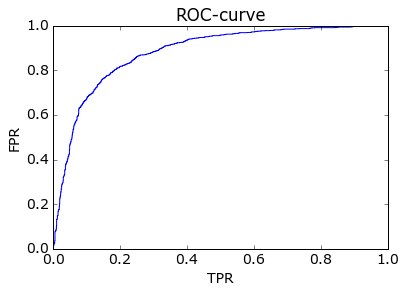

In [109]:
tpr, fpr, roc_tr = roc_curve(y_test, y_pred)
plt.plot(tpr, fpr)
plt.title('ROC-curve')
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.show()

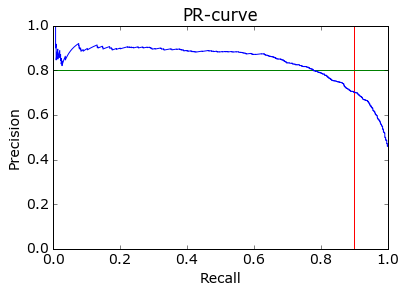

In [110]:
pre, rec, pr_tr = precision_recall_curve(y_test, y_pred)
plt.plot(rec, pre)
plt.title('PR-curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.vlines(0.9, 0, 1, color='red')
plt.hlines(0.8, 0, 1, color='green')
plt.show()

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [117]:
t = np.argmax(pre[rec >= 0.9])
print('Precision: %.3g, Treshold: %.3g' % (pre[rec >= 0.9][t], pr_tr[rec[:-1] >= 0.9][t]))

Precision: 0.702, Treshold: 0.316


Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [118]:
from sklearn.metrics import f1_score
tresh = pr_tr[t]
print('F-score: %.3g' % f1_score(y_test, y_pred > tresh))

F-score: 0.788


$$F = \frac{2 \times Precision \times Recall}{Precision + Recall}$$

F-мера становится маленькой, когда мала либо точность, либо полнота. В данном случае мы имеем высокую полноту, но низкую точность, поэтому и небольшую F-меру.

Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

In [119]:
t = np.argmax(rec[pre >= 0.8])
print('Recall: %.3g, Treshold: %.3g' % (rec[pre >= 0.8][t], pr_tr[pre[:-1] >= 0.8][t]))

Recall: 0.778, Treshold: 0.528


#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [125]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios)

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая?

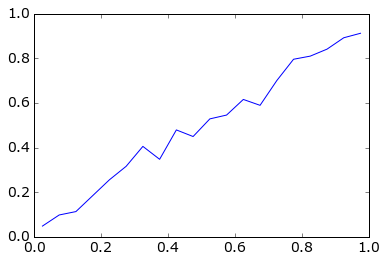

In [126]:
clf = LogisticRegression(C=1.0)
clf.fit(X, y_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Да, достаточно диагональная

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

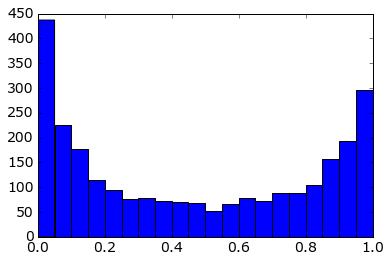

In [127]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [157]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, y_train)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? Чем вы можете объяснить это?

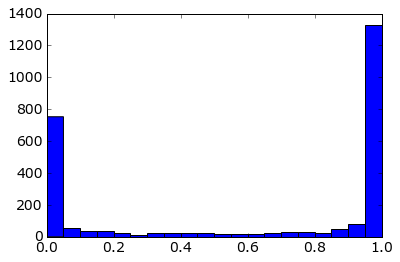

In [158]:
plt.hist(preds, bins=20)
plt.show()

Большей части объектов классификатор присвоил значения, близкие к 0 или 1. Это связано с тем, что выход линейной модели получается слишком большим по модулю, и после применения сигмоиды он оказывается близок к 0 и 1.

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней?

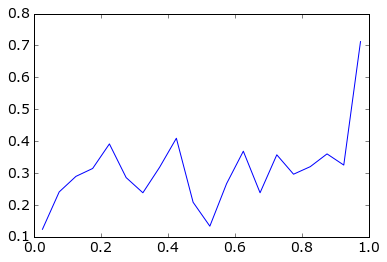

In [159]:
plot_calibration_curve(y_test, preds)

Калибровочная кривая совершенно не похожа на диагональную.

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

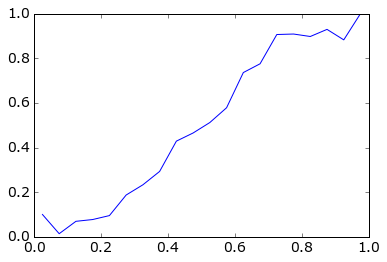

In [164]:
from sklearn.calibration import CalibratedClassifierCV
cc = CalibratedClassifierCV(SGDClassifier(loss='hinge'), cv=5)
cc.fit(X, y_train)
preds = cc.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Эта кривая заметно больше похожа на диагональную

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

<img src='http://media.vorotila.ru/ru/items/t1@9d3fa566-ede2-416d-9597-a136fa9bbe83/udivitelnaya-Avstraliya.jpg' width=50%>

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [168]:
X['Bias'] = 1
X_test['Bias'] = 1

In [170]:
y_train = y_train * 2 - 1
y_test = y_test * 2 - 1

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [172]:
def sigma(x):
    return 1 / (1 + np.exp(-x))

In [173]:
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    return sigma(X.dot(w))

In [252]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
    return np.log(1 + np.exp(-y * X.dot(w))).mean()

In [253]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    return -((y * sigma(-y * X.dot(w)))[:, np.newaxis] * X).mean(axis=0)

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [259]:
def grad_descent(X, y, step_size, max_iter):
    w = np.ones(X.shape[1])
    func = [get_func(w, X, y)]
    for i in range(max_iter):
        g = get_grad(w, X, y)
        w -= g * step_size
        func.append(get_func(w, X, y))
    return w, np.array(func)

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

In [277]:
w = []
f = []
step = [0.001, 1, 10]
for i in step:
    w1, f1 = grad_descent(X, y_train, i, 30)
    w.append(w1)
    f.append(f1)

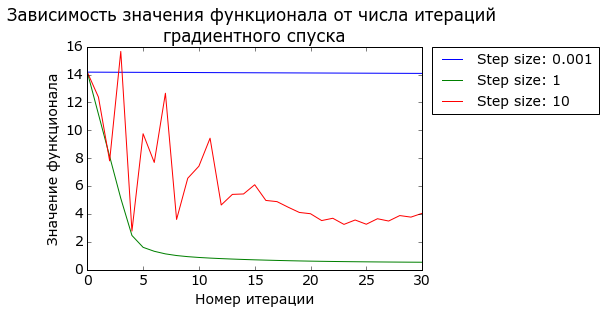

In [278]:
for i, s in enumerate(step):
    plt.plot(f[i], label='Step size: %g' % s)
plt.legend(bbox_to_anchor=(1.01, 1.03), loc='upper left')
plt.title('Зависимость значения функционала от числа итераций \nградиентного спуска')
plt.xlabel('Номер итерации')
plt.ylabel('Значение функционала')
plt.show()

Как видно из графика, шаг 0.001 - слишком маленький, функционал сходится очень медленно. Шаг 10 - слишком большой, значение функционала скачет, он проскакивает мимо оптимального значения.

In [279]:
y_pred = make_pred(X_test, w[1])
print('AUC-ROC: ', roc_auc_score(y_test, y_pred))

AUC-ROC:  0.800758279809


Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [273]:
def sgd(X, y, step_size, max_iter):
    pos = np.random.randint(0, X.shape[0], max_iter)
    w = np.ones(X.shape[1])
    func = [get_func(w, X, y)]
    for i in range(max_iter):
        g = get_grad(w, X.iloc[pos[i]:pos[i] + 1], y.iloc[pos[i]:pos[i] + 1])
        w -= g * step_size
        func.append(get_func(w, X, y))
    return w, np.array(func)

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке.

In [300]:
w = []
f = []
step = [0.03, 0.1, 0.3, 1, 3]
for i in step:
    w1, f1 = sgd(X, y_train, i, 100)
    w.append(w1)
    f.append(f1)

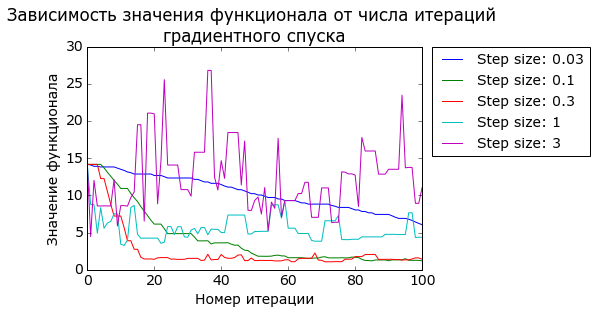

In [301]:
for i, s in enumerate(step):
    plt.plot(f[i], label='Step size: %g' % s)
plt.legend(bbox_to_anchor=(1.01, 1.03), loc='upper left')
plt.title('Зависимость значения функционала от числа итераций \nградиентного спуска')
plt.xlabel('Номер итерации')
plt.ylabel('Значение функционала')
plt.show()

Наименьшее значение функционала достигается при шаге 0.3.

In [302]:
y_pred = make_pred(X_test, w[2])
print('AUC-ROC: ', roc_auc_score(y_test, y_pred))

AUC-ROC:  0.735466844202


А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

In [304]:
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X_unsc, scaler, transformer = transform_data(data_train, scaler, transformer, False, scale=False)
X_test_unsc, _, _ = transform_data(data_test, scaler, transformer, True, scale=False)

C:\Anaconda3\lib\site-packages\pandas\core\internals.py:4417: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  comp = (nn == nn_at)


In [309]:
X_unsc['Bias'] = 1
X_test_unsc['Bias'] = 1

In [337]:
w, f = grad_descent(X_unsc / 100, y_train, 0.003, 50)

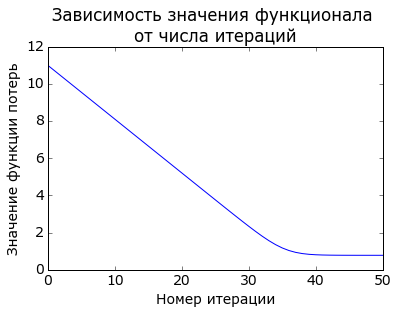

In [343]:
plt.plot(f)
plt.title('Зависимость значения функционала \nот числа итераций')
plt.xlabel('Номер итерации')
plt.ylabel('Значение функции потерь')
plt.show()

In [339]:
y_pred = make_pred(X_test_unsc / 100, w)
print('AUC-ROC: ', roc_auc_score(y_test, y_pred))

AUC-ROC:  0.454216328225


Странно. Предсказывает хуже, чем наугад. Попробуем наоборот.

In [341]:
y_pred = make_pred(X_test_unsc / 100, w)
print('AUC-ROC: ', roc_auc_score(y_test, -y_pred))

AUC-ROC:  0.545783671775


Результат необъяснимо абсурдный. Видимо, это значит, что признаки лучше масштабировать.

Здесь вы можете поделиться своими мыслями по поводу этой части.

<img src='https://pp.vk.me/c622325/v622325277/2793b/uHOtxVsO4sI.jpg' width=50%>

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [345]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве тестовой выборки. При каком значении этого параметра достигается наилучшее качество?

In [346]:
alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [351]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [363]:
gs = GridSearchCV(Ridge(), {'alpha': alpha_grid}, scoring='mean_squared_error', cv=5)
gs = gs.fit(X, y)

In [359]:
gs.best_params_

{'alpha': 0.001}

In [360]:
gs.best_score_

-3017.4310798083438

Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

In [367]:
print('RMSE:', mean_squared_error(y_test, gs.best_estimator_.predict(X_test)) ** 0.5)
print('R^2 score:', r2_score(y_test, gs.best_estimator_.predict(X_test)))

RMSE: 55.8577676405
R^2 score: 0.412493728283


0.41 - это очень низкий коэффициент детерминизации, модель очень далека от оптимальной